## Actitracker dataset
Evaluation for capstone model-building.

#### load libraries

In [12]:
import keras
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import scipy as sp
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8, 6)

### Exploring the data

In [ ]:
!cat WISDM_ar_v1.1_raw.txt | awk -F',' 'BEGIN { OFS=","; RS=";"; ORS=";"; } \
{ if (NF==6) { print $0,"" } else if (NF==7) { print $0 }}' > raw_data_fixed.txt

In [5]:
DATA_FOLDER = 'Data/WISDM_ar_v1.1/'
DATA_FILE = 'raw_data_fixed.txt'

In [6]:
actitracker = pd.read_csv(
    DATA_FOLDER+DATA_FILE ,
    sep=',' ,
    lineterminator=';' ,
    header=None ,
)

In [7]:
actitracker.columns = [
    'user' ,
    'activity' ,
    'timestamp' ,
    'x-accel' ,
    'y-accel' ,
    'z-accel' ,
    'NA' ,
]
del actitracker['NA']

In [8]:
actitracker[['x-accel','y-accel','z-accel']].describe()

,x-accel,y-accel,z-accel
count,1098208.000000,1098208.000000,1098208.000000
mean,0.662866,7.255626,0.411078
std,6.849046,6.746216,4.754120
min,-19.610000,-19.610000,-19.800000
25%,-2.870000,3.170000,-2.220000
50%,0.270000,7.930000,0.000000
75%,4.440000,11.560000,2.720000
max,19.950000,20.040000,19.610000


In [9]:
sample = np.random.choice(xrange(actitracker.shape[0]), 2000)

In [10]:
X, Y, Z = actitracker[['x-accel']].as_matrix()[sample].ravel() , \
actitracker[['y-accel']].as_matrix()[sample].ravel() , \
actitracker[['z-accel']].as_matrix()[sample].ravel()

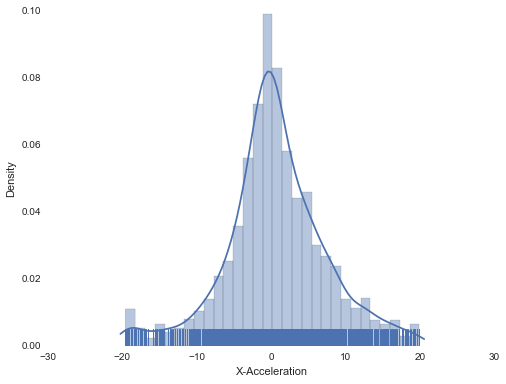

In [11]:
sns.distplot(X, bins=30, rug=True)
sns.axlabel('X-Acceleration','Density')

In [13]:
sp.stats.shapiro(X)

(0.9751362204551697, 3.7143523838637205e-18)

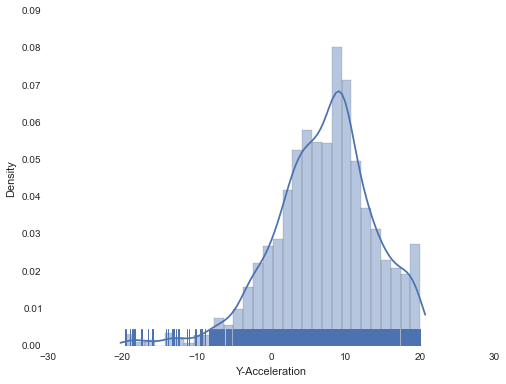

In [14]:
sns.distplot(Y, bins=30, rug=True)
sns.axlabel('Y-Acceleration','Density')

In [15]:
sp.stats.shapiro(Y)

(0.9753621816635132, 4.547059803679521e-18)

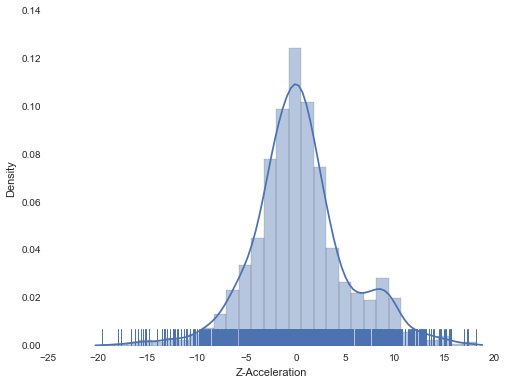

In [16]:
sns.distplot(Z, bins=30, rug=True)
sns.axlabel('Z-Acceleration','Density')

In [17]:
sp.stats.shapiro(Z)

(0.9740719795227051, 1.4575777491142574e-18)

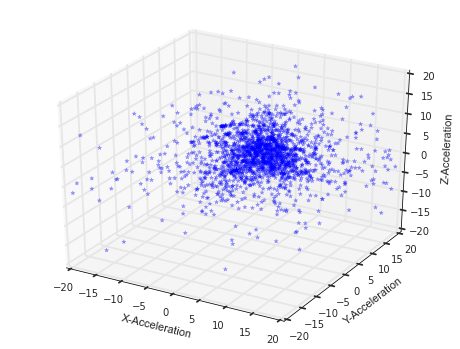

In [228]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
lims = [-20,20]
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_zlim(lims)
ax.set_xlabel('X-Acceleration')
ax.set_ylabel('Y-Acceleration')
ax.set_zlabel('Z-Acceleration')
plt.scatter(X, Y, zs=Z, axes=ax, marker='*', color='blue', alpha=0.4)

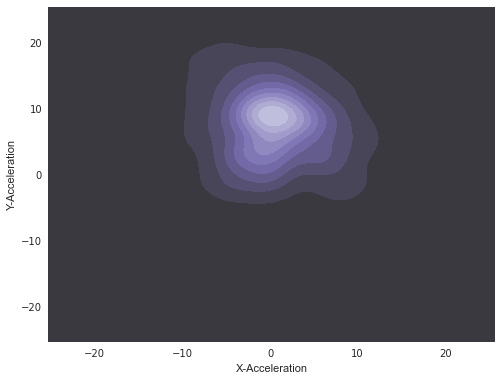

In [213]:
sns.kdeplot(
    X ,
    Y ,
    cmap="Purples_d" ,
    shade=True ,
)
sns.axlabel('X-Acceleration','Y-Acceleration')


In [22]:
sp.stats.spearmanr(X,Y)

SpearmanrResult(correlation=0.01581696181120831, pvalue=0.47959255842062753)

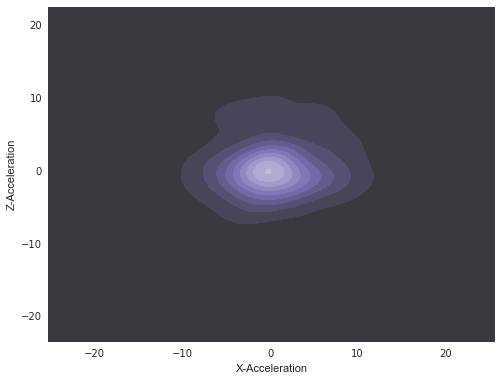

In [221]:
sns.kdeplot(
    X ,
    Z ,
    cmap="Purples_d" ,
    shade=True ,
)
sns.axlabel('X-Acceleration','Z-Acceleration')

In [23]:
sp.stats.spearmanr(X,Z)

SpearmanrResult(correlation=0.064309979461828232, pvalue=0.0040120815072710305)

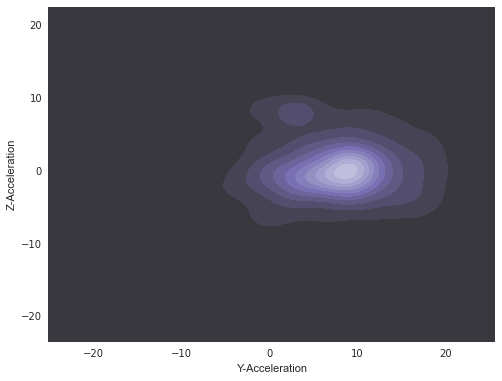

In [222]:
sns.kdeplot(
    Y ,
    Z ,
    cmap="Purples_d" ,
    shade=True ,
)
sns.axlabel('Y-Acceleration','Z-Acceleration')

In [24]:
sp.stats.spearmanr(Y,Z)

SpearmanrResult(correlation=-0.0076181544854933367, pvalue=0.73349043519866086)

In [207]:
D = actitracker.iloc[sample][['x-accel','y-accel','z-accel','activity']]

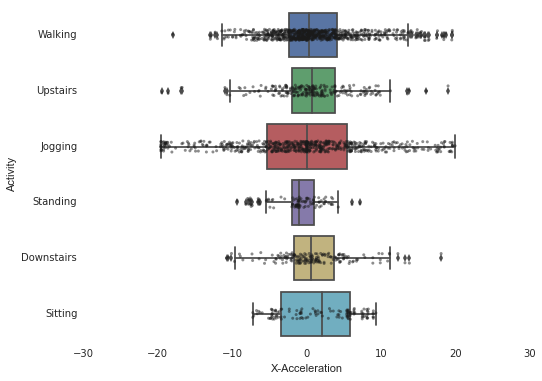

In [223]:
sns.boxplot(x='x-accel',y='activity',data=D)
sns.stripplot(x="x-accel", y="activity", data=D,
              jitter=True, size=3, color=".1", alpha=0.5, linewidth=0)
sns.axlabel('X-Acceleration','Activity')

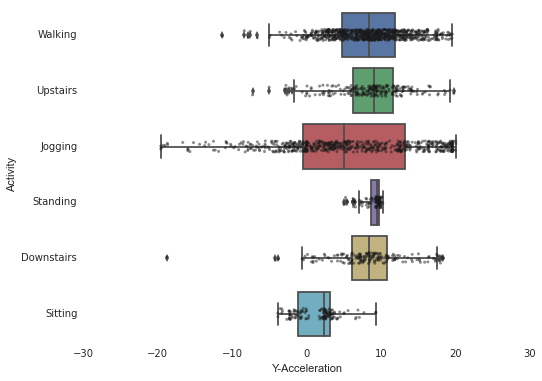

In [224]:
sns.boxplot(x='y-accel',y='activity',data=D)
sns.stripplot(x="y-accel", y="activity", data=D,
              jitter=True, size=3, color=".1", alpha=0.5, linewidth=0)
sns.axlabel('Y-Acceleration','Activity')

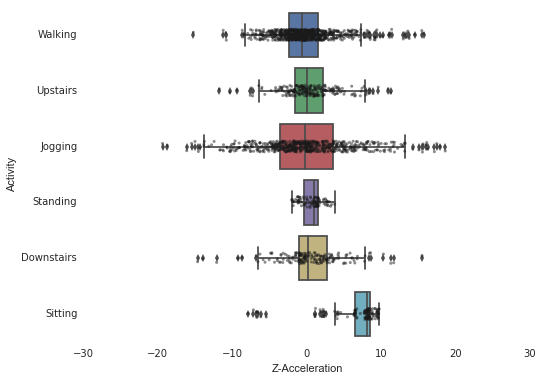

In [225]:
sns.boxplot(x='z-accel',y='activity',data=D)
sns.stripplot(x="z-accel", y="activity", data=D,
              jitter=True, size=3, color=".1", alpha=0.5, linewidth=0)
sns.axlabel('Z-Acceleration','Activity')

### Evaluate time blocks

In [295]:
actitracker['time_seconds'] = actitracker['timestamp']*10e-9
actitracker = actitracker.sort_values(by=['user','time_seconds'])
actitracker.index = xrange(actitracker.shape[0])

In [344]:
offset_index = actitracker.iloc[1:].index
actitracker.loc[offset_index,'time_seconds_prev'] = actitracker.iloc[:-1]['time_seconds'].as_matrix()
actitracker.loc[offset_index,'prev_user'] = actitracker.iloc[:-1]['user'].as_matrix()

In [345]:
nonmatched_users = actitracker['user']!=actitracker['prev_user']
actitracker.loc[nonmatched_users,['time_seconds_prev','prev_user']] = np.nan

In [347]:
actitracker['time_diff'] = actitracker['time_seconds'] - actitracker['time_seconds_prev']

In [358]:
nan_filter = -np.isnan(actitracker['time_diff'])
actitracker['time_diff'].describe()

count    1098172.000000
mean           7.659919
std         2239.629216
min            0.000000
25%            0.495000
50%            0.499880
75%            0.500490
max      1296121.114820
Name: time_diff, dtype: float64

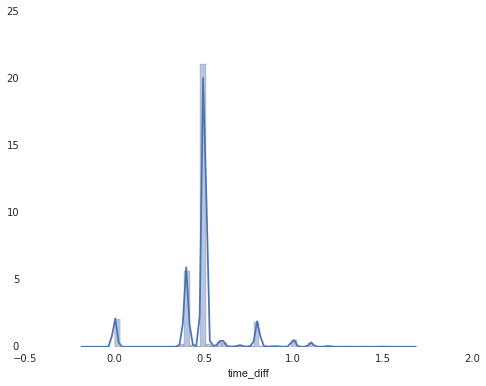

In [370]:
sns.distplot(actitracker.loc[actitracker['time_diff']<1.5,'time_diff'])